# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import string
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop

# Loading the data

In [2]:
df = pd.read_csv('mozilla_core.csv')
# filtering the dataset for only useful columns
df = df[['Title','Description','Resolution']]

# dropping the rows having missing values
df.dropna(inplace = True)

# Creating labels for the dataset

In [3]:
# creating a list that will sore the target labels
target = []

# iterating through the resolution column and setting 1 if duplicate and 0 if not
for i in df['Resolution']:
    if 'duplicate' in i.lower():
        target.append(1)
    else:
        target.append(0)
        
# creating a column named Target and storing the target list values in it        
df['Target'] = target 

In [44]:
df.head()

,Title,Description,Resolution,Target,text
100550,shutdown crash [@ nsAppStartup::HandleExitEven...,steps:; run winembed; load chrome://global/con...,WORKSFORME,0,shutdown crash nsappstartuphandleexitevent map...
156124,useless assert of free_block [@ CodeAlloc::free],147 void CodeAlloc::free(NIns* start; NIns...,FIXED,0,useless assert freeblock codeallocfree void co...
165795,expose layout-guess: true object attribute for...,We should expose layout-guess: true object att...,FIXED,0,expose layoutguess true object attribute datat...
61730,Use OS-specific scrollbars in Print Prview as ...,Why are the scrollbars in Print Preview differ...,DUPLICATE,1,use osspecific scrollbars print prview well sc...
120910,Crash while trying to print [@ @0x0 @0x1000 _c...,With every page; this crash happens for me her...,FIXED,0,crash trying print x x cairometasurfacecreate ...


# Checking for balanced dataset

class 0: (156997, 4)
class 1: (44651, 4)


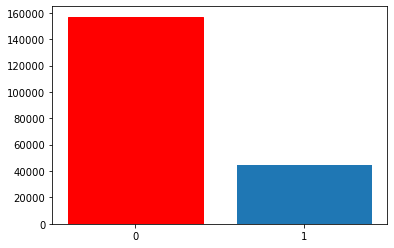

In [4]:
class_count_0, class_count_1 = df['Target'].value_counts()

# Separate class
class_0 = df[df['Target'] == 0]
class_1 = df[df['Target'] == 1]

# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

bar = plt.bar(['0','1'],df['Target'].value_counts())
bar[0].set_color('r')

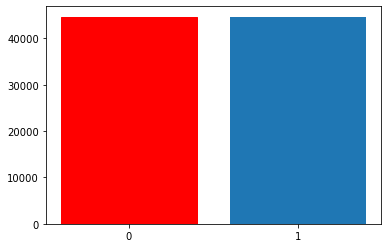

In [5]:
# balancing the dataset using undersampling as the dataset is highly imbalanced
class_0_under = class_0.sample(class_count_1)

df = pd.concat([class_0_under, class_1], axis=0)

# plot the count after under-sampeling
bar = plt.bar(['0','1'],df['Target'].value_counts())
bar[0].set_color('r')

In [45]:
# shuffling the dataset 
df = df.sample(frac=1) 

# creating a new column and adding the title and description in it 
df['text'] = df['Title'] +' '+ df['Description']
df = df[['text','Target']]
df.head()

,text,Target
110188,Method queryCommandState doesnt get correct st...,0
33300,Mac Scrollwheel support does not work with Ken...,1
202621,Use a draw target in ThebesLayerBuffer::PaintS...,0
9771,Exclude certain items from the script-generate...,0
19415,ftp download never ends Downloading over ftp w...,1


# Preprocessing the dataset

In [7]:
# converting the text to lowercase
def lower(words):
    return words.lower()
df['text']=df['text'].apply(lambda x:lower(x))

In [8]:
# removing the numbers from the text
def remove_numbers(words):
    return re.sub(r'\d+','',words)
df['text']=df['text'].apply(lambda x: remove_numbers(x))

In [9]:
# removing the puctuations from the text
def remove_punctuation(words):
    table=str.maketrans('','',string.punctuation)
    return words.translate(table)
df['text']=df['text'].apply(lambda x: remove_punctuation(x))


In [10]:
# tokenizing the text column
df['text']=df['text'].apply(lambda x:word_tokenize(x))
def remove_stopwords(words):
    stop_words=set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]
df['text']=df['text'].apply(lambda x: remove_stopwords(x))

In [11]:
# Lemmatizing the text column
def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
df['text']=df['text'].apply(lambda x: lemmatizing(x))

In [12]:
# joining or merging the tokenized text
def final_text(words):
     return ' '.join(words)
df['text']=df['text'].apply(lambda x:final_text(x))

# Vectorizing (Feature Extraction)

In [15]:

MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = df['Target']



# Splitting the dataset into train and test

In [31]:
X_train = X[:len(X)-3000]
X_test = X[len(X)-3000:]
Y_train = Y[:len(X)-3000]
Y_test = Y[len(X)-3000:]
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(86302, 250) (86302,)
(3000, 250) (3000,)


# Model fitting and predictions

In [36]:
# creating function for the two deep learning models and setting the input layers for them.
def LSTM_model():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_NB_WORDS,100,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(64,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def SimpleRNN_model():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_NB_WORDS,100,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = SimpleRNN(units=100)(layer)
    layer = Dense(64,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [39]:
model1 = LSTM_model()
model1.summary()
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.fit(X_train,Y_train,batch_size=1000,epochs=3)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 250)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 250, 100)          500000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
FC1 (Dense)                  (None, 64)                6464      
_________________________________________________________________
activation_24 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65 

In [40]:
accr = model1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3000/3000 [==============================] - 12s 4ms/sample - loss: 0.6193 - accuracy: 0.6547
Test set
  Loss: 0.619
  Accuracy: 0.655


In [41]:
model2 = SimpleRNN_model()
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.fit(X_train,Y_train,batch_size=1000,epochs=10)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 250)]             0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 250, 100)          500000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
FC1 (Dense)                  (None, 64)                6464      
_________________________________________________________________
activation_26 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65 

In [43]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3000/3000 [==============================] - 3s 1ms/sample - loss: 2.0217 - accuracy: 0.5820
Test set
  Loss: 2.022
  Accuracy: 0.582
